In [57]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from prophet import Prophet
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [58]:
df = pd.read_csv('project_data.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df1=df.copy()

In [59]:
# df21 = df1[['timestamp','AirTC_Avg']].copy()
# df22 = df1[['timestamp','GHI_A_DATA_Avg']].copy()
# df23 = df1[['timestamp','POA_A_DATA_2_Avg']].copy()
# df24 = df1[['timestamp','POA_A_DATA_3_Avg']].copy()
# df25 = df1[['timestamp','WS_Avg']].copy()
# df26 = df1[['timestamp','ActivePowerKw']].copy()

# df21 = df21.resample('H',on = 'timestamp').median()
# df22 = df22.resample('H',on = 'timestamp').median()
# df23 = df23.resample('H',on = 'timestamp').median()
# df24 = df24.resample('H',on = 'timestamp').median()
# df25 = df25.resample('H',on = 'timestamp').median()
# df26 = df26.resample('H',on = 'timestamp').median()

In [60]:
# df211 = df21.merge(df23, on='timestamp')
# df212 = df22.merge(df24, on='timestamp')
# df213 = df25.merge(df26, on='timestamp')

# df214 = df211.merge(df213, on='timestamp')
# df215 = df212.merge(df214, on='timestamp')
# df = df215.dropna().copy()

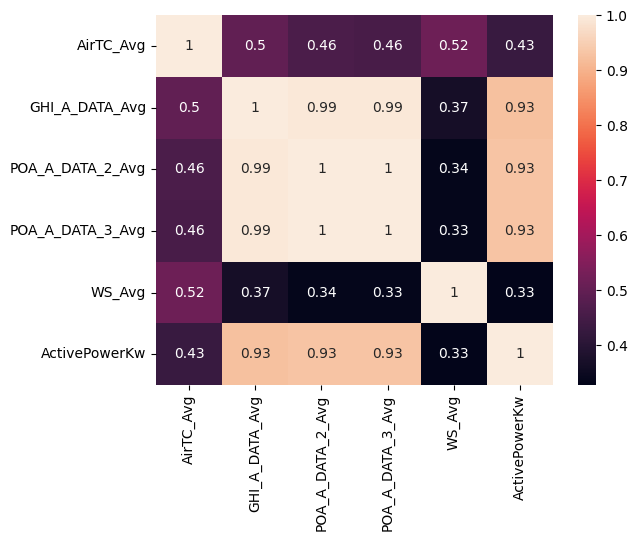

In [61]:
correlation_mat = df.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AirTC_Avg,296897.0,23.866668,7.641984,4.28300,18.750000,24.350000,28.93,43.64
GHI_A_DATA_Avg,296897.0,209.548634,302.451636,-12.00000,-2.000000,3.166667,382.00,1385.00
POA_A_DATA_2_Avg,296897.0,222.963379,322.142763,-11.00000,-1.000000,4.000000,401.00,1387.00
POA_A_DATA_3_Avg,296897.0,222.266810,321.564246,-12.83333,-1.666667,3.333333,400.00,1381.00
WS_Avg,296897.0,6.718948,6.174216,0.35600,1.059000,5.103000,10.14,52.01
ActivePowerKw,296897.0,233.814701,334.363103,0.00000,0.000000,0.000000,435.70,2105.60


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296897 entries, 0 to 296896
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         296897 non-null  datetime64[ns]
 1   AirTC_Avg         296897 non-null  float64       
 2   GHI_A_DATA_Avg    296897 non-null  float64       
 3   POA_A_DATA_2_Avg  296897 non-null  float64       
 4   POA_A_DATA_3_Avg  296897 non-null  float64       
 5   WS_Avg            296897 non-null  float64       
 6   ActivePowerKw     296897 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 15.9 MB


In [64]:
df.isnull().sum()

timestamp           0
AirTC_Avg           0
GHI_A_DATA_Avg      0
POA_A_DATA_2_Avg    0
POA_A_DATA_3_Avg    0
WS_Avg              0
ActivePowerKw       0
dtype: int64

In [65]:
def decompose_Ac_demand(df, share_type='ActivePowerKw', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

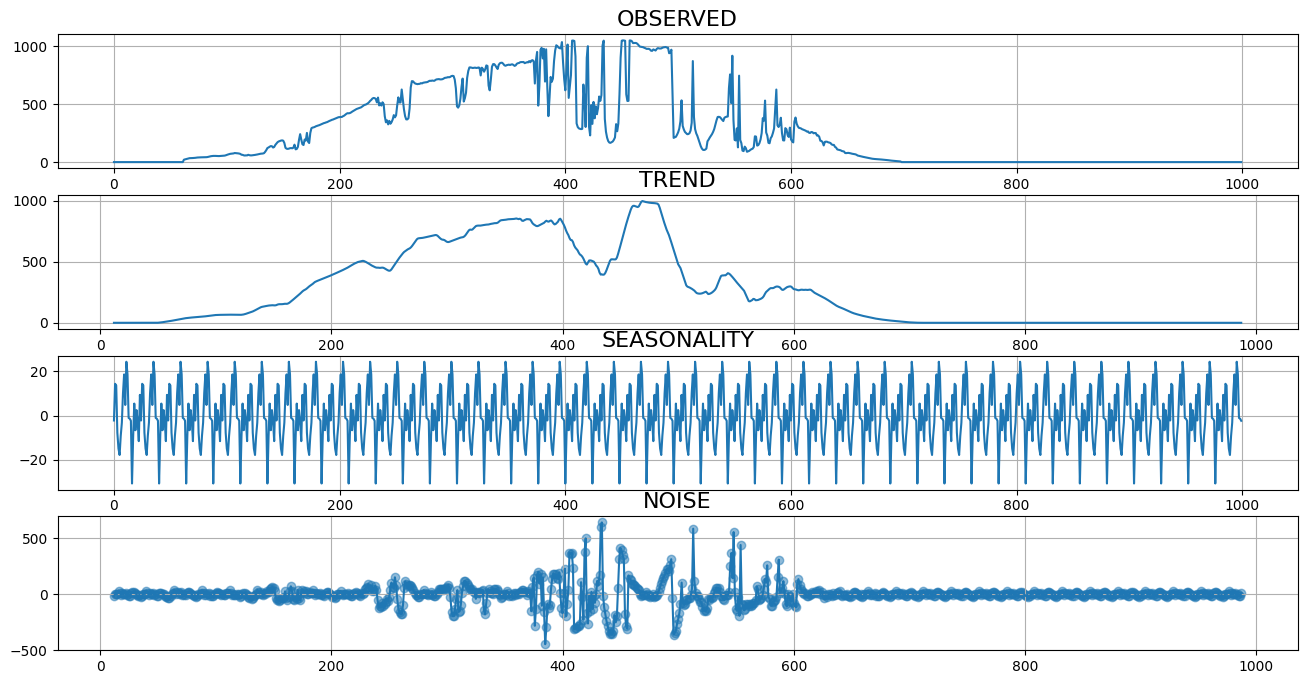

In [66]:
decompose_Ac_demand(df, samples=1000, period=24)

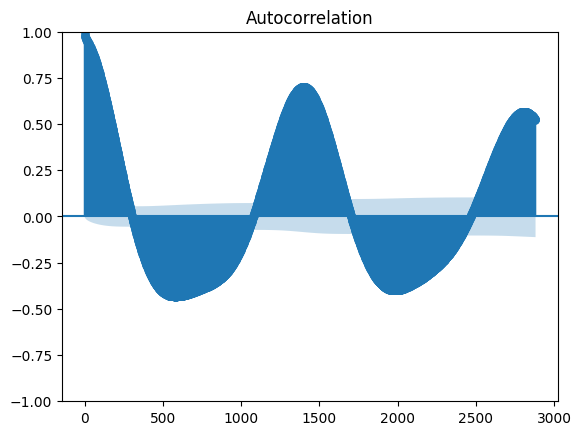

In [67]:
plot_acf(df['ActivePowerKw'].values, lags=48*60)
plt.show()

In [68]:
def prophet_features(df, horizon=24*60*7):
    temp_df = df.reset_index()
    temp_df = temp_df[['timestamp', 'ActivePowerKw']]
    temp_df.rename(columns={'timestamp': 'ds', 'ActivePowerKw': 'y'}, inplace=True)
    
    #take last week of the dataset for validation
    train, test = temp_df.iloc[:-horizon,:], temp_df.iloc[-horizon:,:]
    
    #define prophet model
    m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )
    #train prophet model
    m.fit(train)
    
    #extract features from data using prophet to predict train set
    predictions_train = m.predict(train.drop('y', axis=1))
    #extract features from data using prophet to predict test set
    predictions_test = m.predict(test.drop('y', axis=1))
    #merge train and test predictions
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions

In [69]:
def train_time_series_with_folds_autoreg_prophet_features(df, horizon=24*60*7, lags=[1, 2, 3, 4, 5]):
    #create a dataframe with all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon)
    df.reset_index(inplace=True)
    
    #merge the Prophet features dataframe with the our first dataframe
    df = pd.merge(df, new_prophet_features, left_on=['timestamp'], right_on=['ds'], how='inner')
    df.drop('ds', axis=1, inplace=True)
    df.set_index('timestamp', inplace=True)
    
    #create some lag variables using Prophet predictions (yhat column)
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any')
    
    X = df.drop('ActivePowerKw', axis=1)
    y = df['ActivePowerKw']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #define LightGBM model, train it and make predictions
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Timestamp', fontsize=16)
    plt.ylabel('Ac Power Kw', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #calculate MAE
    y_test_1 = y_test.last('24h')
    mae = np.round(mean_absolute_error(y_test_1, predictions[-1293:]), 3)  
    
    #plot reality vs prediction for the last 1 day of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test_1, color='red')
    plt.plot(pd.Series(predictions[-1293:], index=y_test_1.index), color='green')
    plt.xlabel('Timestamp', fontsize=16)
    plt.ylabel('Ac Power Kw', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


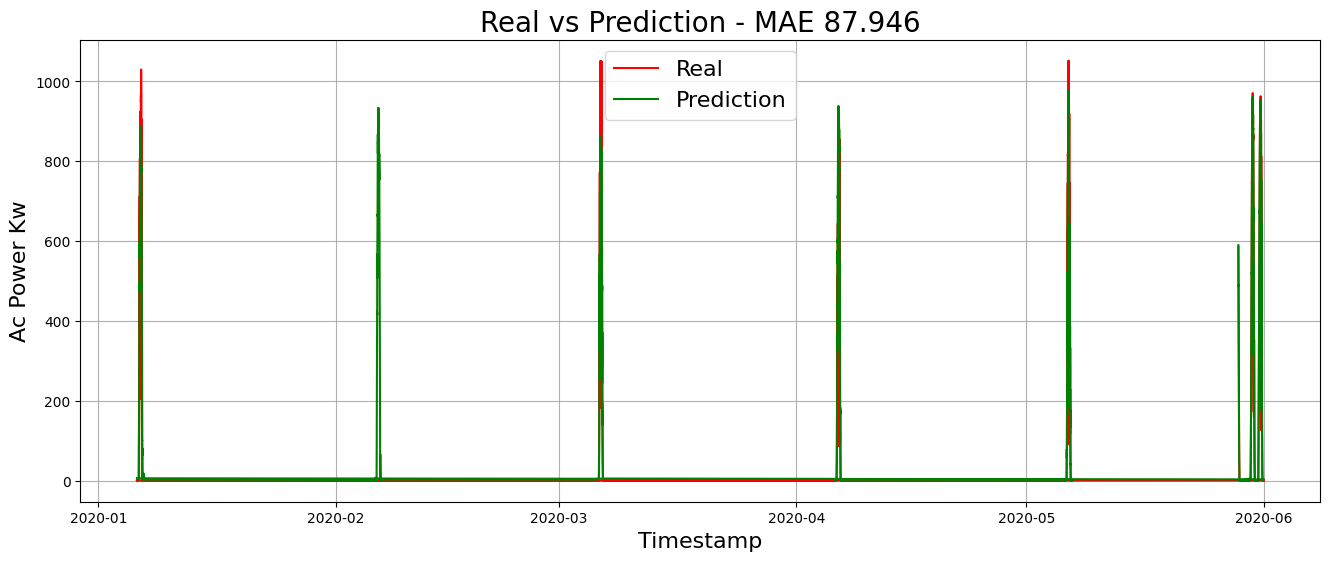

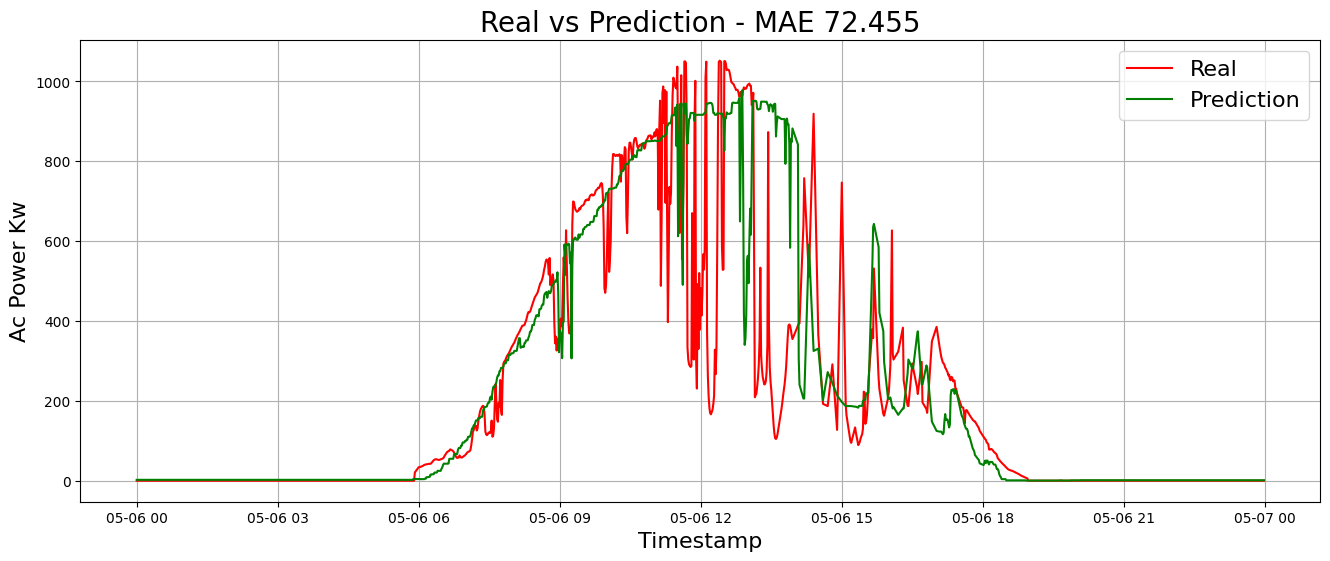

In [70]:
train_time_series_with_folds_autoreg_prophet_features(df)